In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException
from bs4 import BeautifulSoup
import time
import matplotlib.pyplot as plt
import csv
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
from IPython.display import display
import re
from tqdm.notebook import tqdm
import networkx as nx
import numpy as np
from datetime import datetime, timedelta
import os
from PIL import ImageFile

# Make a df from images

In [32]:
def get_image_info(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
        avg_color = np.array(img).mean(axis=(0, 1)).astype(int)
        avg_color_hex = '#{:02x}{:02x}{:02x}'.format(*avg_color[:3])
        return (width, height), avg_color_hex

def create_image_df(root_folder, cutoff=1000):
    data = []
    # for subdir, _, files in os.walk(root_folder):
    counter = 0
    for subdir, _, files in tqdm(os.walk(root_folder), desc='Processing images'):
        for file in files:
            if file.lower().endswith(('.jpg')):
                image_path = os.path.join(subdir, file)
                dimensions, avg_color = get_image_info(image_path)
                data.append([image_path, dimensions, avg_color])
                counter += 1
            if counter > cutoff:
                break
        if counter > cutoff:
            break
    
    df = pd.DataFrame(data, columns=['Path', 'Dimensions', 'Average Color'])
    return df

In [33]:
# Define the root folder
root_folder = '../crawling/images_all/'

# Create the DataFrame
df = create_image_df(root_folder, cutoff = 10000)

# Save the DataFrame to a CSV file
df.to_csv('image_data.csv', index=False)

Processing images: 0it [00:00, ?it/s]

# make mosaic

In [21]:
def get_average_color(image):
    return np.array(image).mean(axis=(0, 1)).astype(int)

def convert_color(color):
    if isinstance(color, str) and color.startswith('#'):
        return tuple(int(color[i:i+2], 16) for i in (1, 3, 5))
    return eval(color)

def find_closest_image(avg_color, df):
    df['Color Distance'] = df['Average Color'].apply(lambda x: np.linalg.norm(np.array(x) - avg_color))
    return df.loc[df['Color Distance'].idxmin()]['Path']

def create_mosaic(target_image_path, df):
    target_image = Image.open(target_image_path)
    target_width, target_height = target_image.size
    mosaic_image = Image.new('RGB', (target_width, target_height))

    x, y = 0, 0
    while y < target_height:
        while x < target_width:
            avg_color = get_average_color(target_image.crop((x, y, x + 1, y + 1)))
            closest_image_path = find_closest_image(avg_color, df)
            closest_image = Image.open(closest_image_path)
            img_width, img_height = closest_image.size

            if x + img_width > target_width:
                img_width = target_width - x
            if y + img_height > target_height:
                img_height = target_height - y

            closest_image = closest_image.resize((img_width, img_height), Image.LANCZOS)
            mosaic_image.paste(closest_image, (x, y))

            x += img_width
        x = 0
        y += img_height

    return mosaic_image

In [22]:
# Load the DataFrame
df = pd.read_csv('image_data.csv')

df['Average Color'] = df['Average Color'].apply(convert_color)

# Define the target image path and tile size
target_image_path = './images/DJI_0153.JPG'

# Create the mosaic
mosaic_image = create_mosaic(target_image_path, df)

# Save the mosaic image
mosaic_image.save('mosaic_image.jpg')

# other approach

In [36]:
def get_average_color(image):
    return np.array(image).mean(axis=(0, 1)).astype(int)

def convert_color(color):
    if isinstance(color, str) and color.startswith('#'):
        return tuple(int(color[i:i+2], 16) for i in (1, 3, 5))
    return eval(color)

def find_closest_image(avg_color, df):
    df['Color Distance'] = df['Average Color'].apply(lambda x: np.linalg.norm(np.array(x) - avg_color))
    return df.loc[df['Color Distance'].idxmin()]['Path']

# def create_mosaic(target_image_path, df, tile_size):
#     target_image = Image.open(target_image_path)
#     target_width, target_height = target_image.size
#     mosaic_image = Image.new('RGB', (target_width, target_height))

#     for y in range(0, target_height, tile_size[1]):
#         for x in range(0, target_width, tile_size[0]):
#             box = (x, y, x + tile_size[0], y + tile_size[1])
#             tile = target_image.crop(box)
#             avg_color = get_average_color(tile)
#             closest_image_path = find_closest_image(avg_color, df)
#             closest_image = Image.open(closest_image_path)
#             closest_image = closest_image.resize(tile_size, Image.LANCZOS)
#             mosaic_image.paste(closest_image, box)

#     return mosaic_image

def create_mosaic(target_image_path, df, tile_size):
    target_image = Image.open(target_image_path)
    target_width, target_height = target_image.size
    mosaic_image = Image.new('RGB', (target_width, target_height))

    for y in tqdm(range(0, target_height, tile_size[1]), desc="Rows"):
        for x in range(0, target_width, tile_size[0]):
            box = (x, y, x + tile_size[0], y + tile_size[1])
            tile = target_image.crop(box)
            avg_color = get_average_color(tile)
            closest_image_path = find_closest_image(avg_color, df)
            closest_image = Image.open(closest_image_path)
            closest_image = closest_image.resize(tile_size, Image.LANCZOS)

            # Create a new image with the average color as the background
            background = Image.new('RGB', tile_size, tuple(avg_color))
            background.paste(closest_image, (0, 0))

            mosaic_image.paste(background, box)

    return mosaic_image

In [37]:
# Load the DataFrame
df = pd.read_csv('image_data.csv')

# Convert Average Color from hex or string representation to tuple
df['Average Color'] = df['Average Color'].apply(convert_color)

# Define the target image path and tile size
target_image_path = './images/DJI_0153.JPG'
tile_size = (20, 20)  # Adjust the tile size to be smaller

# Create the mosaic
mosaic_image = create_mosaic(target_image_path, df, tile_size)

# Save the mosaic image
mosaic_image.save('mosaic_image_4.jpg')

Rows:   0%|          | 0/183 [00:00<?, ?it/s]

## with rescaling

In [45]:
def get_average_color(image):
    avg_color = np.array(image).mean(axis=(0, 1)).astype(int)
    if len(avg_color) == 4:  # If the image has an alpha channel
        avg_color = avg_color[:3]  # Discard the alpha channel
    return avg_color


def convert_color(color):
    if isinstance(color, str) and color.startswith('#'):
        return tuple(int(color[i:i+2], 16) for i in (1, 3, 5))
    return eval(color)

def find_closest_image(avg_color, df):
    df['Color Distance'] = df['Average Color'].apply(lambda x: np.linalg.norm(np.array(x) - avg_color))
    return df.loc[df['Color Distance'].idxmin()]['Path']

def create_mosaic(target_image_path, df, tile_size, upscale_factor=2):
    target_image = Image.open(target_image_path)
    target_width, target_height = target_image.size

    # Resize the target image to a higher resolution
    target_image = target_image.resize((target_width * upscale_factor, target_height * upscale_factor), Image.LANCZOS)
    target_width, target_height = target_image.size

    mosaic_image = Image.new('RGB', (target_width, target_height))

    for y in tqdm(range(0, target_height, tile_size[1]), desc="Rows"):
        for x in range(0, target_width, tile_size[0]):
            box = (x, y, x + tile_size[0], y + tile_size[1])
            tile = target_image.crop(box)
            avg_color = get_average_color(tile)
            closest_image_path = find_closest_image(avg_color, df)
            closest_image = Image.open(closest_image_path)
            closest_image = closest_image.resize(tile_size, Image.LANCZOS)

            # Create a new image with the average color as the background
            background = Image.new('RGB', tile_size, tuple(avg_color))
            background.paste(closest_image, (0, 0))

            mosaic_image.paste(background, box)

    return mosaic_image

In [46]:
# Load the DataFrame
df = pd.read_csv('image_data.csv')

# Convert Average Color from hex or string representation to tuple
df['Average Color'] = df['Average Color'].apply(convert_color)

# Define the target image path and tile size
target_image_path = './images/wp10165109.png'
# target_image_path = './images/DJI_0153.JPG'
tile_size = (80, 80)  # Adjust the tile size to be smaller
# tile_size = (160, 160)  # Adjust the tile size to be smaller

# Create the mosaic with a higher resolution
mosaic_image = create_mosaic(target_image_path, df, tile_size, upscale_factor=4)
# mosaic_image = create_mosaic(target_image_path, df, tile_size, upscale_factor=8)

# Save the mosaic image
mosaic_image.save('mosaic_image_genshin_1.jpg')

Rows:   0%|          | 0/103 [00:00<?, ?it/s]

# plot colors

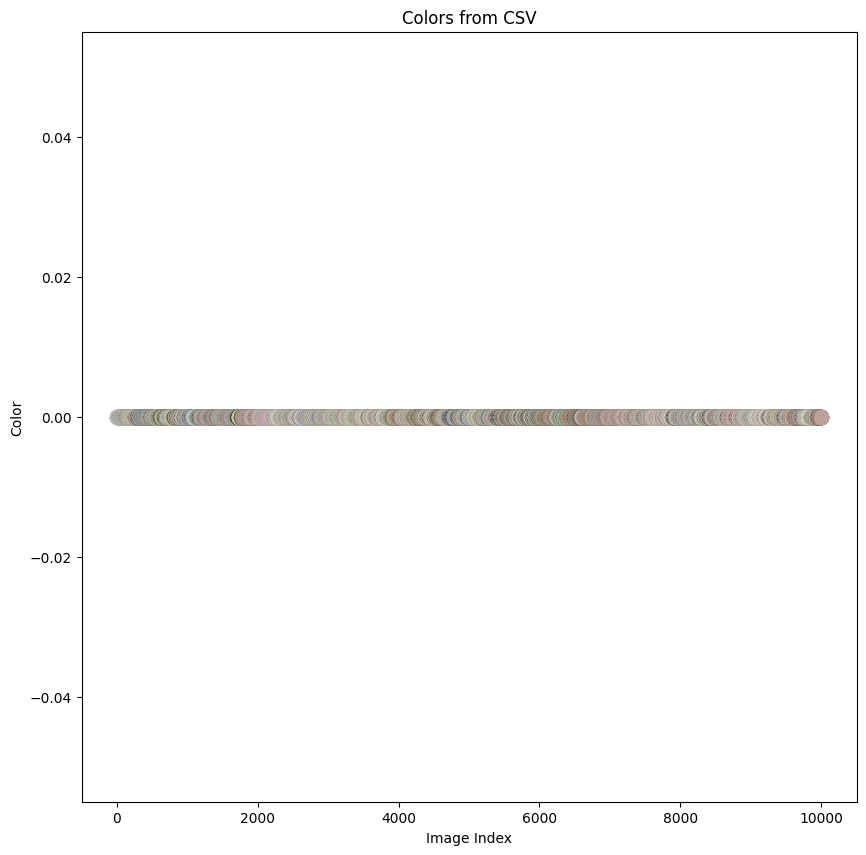

In [35]:
# Load the CSV file
df = pd.read_csv('image_data.csv')

# Convert Average Color from hex or string representation to tuple
def convert_color(color):
    if isinstance(color, str) and color.startswith('#'):
        return tuple(int(color[i:i+2], 16) for i in (1, 3, 5))
    return eval(color)

df['Average Color'] = df['Average Color'].apply(convert_color)

# Normalize the colors to be within 0-1 range
def normalize_color(color):
    return tuple(c / 255.0 for c in color)

df['Normalized Color'] = df['Average Color'].apply(normalize_color)

# Extract the normalized colors
colors = df['Normalized Color'].tolist()

# Plot the colors
plt.figure(figsize=(10, 10))
for i, color in enumerate(colors):
    plt.scatter(i, 0, color=[color], s=100)

plt.title('Colors from CSV')
plt.xlabel('Image Index')
plt.ylabel('Color')
plt.show()